<a href="https://colab.research.google.com/github/shiyuhu1933/EC-523-final-project/blob/main/train_and_test/train_test_ResSaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import torch
import os
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import math
import time
import datetime
from torch import nn, optim
import matplotlib.pyplot as plt 
import torchvision.transforms as T
import pandas as pd
import seaborn as sns
import random

In [ ]:
drive.mount('/content/gdrive')

DATASET_GOOGLE_DRIVE_PATH = '/content/gdrive/MyDrive/Deep Learning /data_hdf5_random_with_aug_no_mask'


def get_file_name(files_list):
  with open(files_list) as f:
    return [line.rstrip()[:] for line in f]

class FaceMaskData(torch.utils.data.Dataset):

  def __init__(self, mode, config, transform=None):

    self.data_dir = DATASET_GOOGLE_DRIVE_PATH
    self.transform = transform

    if mode == 'train':
      self.files = get_file_name(os.path.join(self.data_dir, 'train_files.txt'))
    else:
      self.files = get_file_name(os.path.join(self.data_dir, 'test_files.txt'))

    image = []
    label = []

    for dataset in self.files:
      path = os.path.join(self.data_dir, dataset)
      self.file = h5py.File(path, 'r')
      self.total_num_imgs, self.H, self.W, self.C = self.file['image'].shape
      image.append(self.file['image'][:])
      label.append(self.file['labels'][:])

    self.image= np.vstack(image)
    self.label = np.vstack(label)
    
    self.num_images = len(self.image) 
    self.num_classes = len(np.unique(self.label))

  def __getitem__(self, index):
    """Return one image and its corresponding attribute label."""
    image = self.image[index]
    label = self.label[index]
    if self.transform:
        image = self.transform(image)
    return image, torch.FloatTensor(label)

  def __len__(self):
    return self.num_images
      
  def get_num_class(self):
    return self.num_classes

Mounted at /content/gdrive


In [ ]:
def get_configuration(batch_size):
    config = {}
    config['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    config['batch_size'] = batch_size
    config['num_workers'] = 1
    config['lr'] = 0.0001
    return config

def image_to_rgb(images):
  imgs = []
  for i in range(len(images)):
    image_r = torch.unsqueeze(images[i,:,:,0], 0)
    image_g = torch.unsqueeze(images[i,:,:,1], 0)
    image_b = torch.unsqueeze(images[i,:,:,2], 0)
    image_split_rgb = torch.cat((image_r, image_g, image_b), 0)
    image_split_rgb = torch.unsqueeze(image_split_rgb, 0)
    imgs.append(image_split_rgb)
  return torch.cat(imgs)

def print_network(model, name):
  num_params = 0
  print("\n")
  print("model name", name)
  print(model)
  num_params = sum([par.numel() for par in model.parameters()])
  print("The number of parameters: {}".format(num_params))

def save_model(model, step):
  save_model_path = "/content/gdrive/MyDrive/Deep Learning /models"
  model_path = os.path.join(save_model_path, 'model-{}.ckpt'.format(step))
  torch.save(model, model_path)
  print('Saved model checkpoints into {}...'.format(save_model_path))

def load_model(iters):
  path = "/content/gdrive/MyDrive/Deep Learning /models"
  model_path = os.path.join(path, 'model-{}.ckpt'.format(iters))
  model = torch.load(model_path)
  return model

In [ ]:
config = get_configuration(batch_size=256)
dataset = FaceMaskData('train', config)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                              batch_size=config['batch_size'],
                              shuffle=True, 
                              num_workers=config['num_workers'])
num_classes = dataset.get_num_class()

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    conv3x3 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
    return conv3x3

def conv1x1(in_planes, out_planes, stride=1):
    conv1x1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
    return conv1x1

class FReLU(nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.dw_conv3x3 = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, 3, padding=1, groups=dim_in, bias=False),
            nn.BatchNorm2d(dim_in))

    def forward(self, input):
        output = self.dw_conv3x3(input)
        output = torch.max(input, output)
        return output

In [ ]:
'''modified from BasicBlock in iResNet.ipynb'''

class iBasic(nn.Module):
    exp_block = 1

    def __init__(self, inplanes, outplanes, stride=1, downsample=None, nm_layer=None, s_block=False, e_block=False, exd_bn0=False):
        super(iBasic, self).__init__()
        if nm_layer is None:
            nm_layer = nn.BatchNorm2d
        if not s_block and not exd_bn0:
            self.bn0 = nm_layer(inplanes)

        self.conv1 = conv3x3(inplanes, outplanes, stride)
        self.bn1 = nm_layer(outplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(outplanes, outplanes)

        if s_block:
            self.bn2 = nm_layer(outplanes)

        if e_block:
            self.bn2 = nm_layer(outplanes)

        self.downsample = downsample
        self.stride = stride

        self.s_block = s_block
        self.e_block = e_block
        self.exd_bn0 = exd_bn0

    def forward(self, x):
        identity = x

        if self.s_block:
            out = self.conv1(x)
        elif self.exd_bn0:
            out = self.prelu(x)
            out = self.conv1(out)
        else:
            out = self.bn0(x)
            out = self.prelu(out)
            out = self.conv1(out)

        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)

        if self.s_block:
            out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity

        if self.e_block:
            out = self.bn2(out)
            out = self.prelu(out)

        return out


In [ ]:
class SE_block(nn.Module):
    def __init__(self, inplanes):
        super(SE_block, self).__init__()
        self.se_conv1 = conv1x1(inplanes, inplanes//16)
        self.se_conv2 = conv1x1(inplanes//16, inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        out = self.avgpool(x)
        out = self.se_conv1(out)
        out = self.relu(out)
        out = self.se_conv2(out)
        out = self.sigmoid(out)
        return x * out

'''modified from BasicBlock in iResNet.ipynb'''

class SE_iBasic_F(nn.Module):
    exp_block = 1

    def __init__(self, inplanes, outplanes, stride=1, downsample=None, nm_layer=None, s_block=False, e_block=False, exd_bn0=False):
        super(SE_iBasic_F, self).__init__()
        if nm_layer is None:
            nm_layer = nn.BatchNorm2d
        if not s_block and not exd_bn0:
            self.bn0 = nm_layer(inplanes)

        self.conv1 = conv3x3(inplanes, outplanes, stride)
        self.bn1 = nm_layer(outplanes)
        self.frelu1 = FReLU(inplanes)
        self.frelu2 = FReLU(outplanes)
        self.conv2 = conv3x3(outplanes, outplanes)
        self.se = SE_block(outplanes)

        if s_block:
            self.bn2 = nm_layer(outplanes)

        if e_block:
            self.bn2 = nm_layer(outplanes)

        self.downsample = downsample
        self.stride = stride

        self.s_block = s_block
        self.e_block = e_block
        self.exd_bn0 = exd_bn0

    def forward(self, x):
        identity = x

        if self.s_block:
            out = self.conv1(x)
        elif self.exd_bn0:
            out = self.frelu1(x)
            out = self.conv1(out)
        else:
            out = self.bn0(x)
            out = self.frelu2(out)
            out = self.conv1(out)

        out = self.bn1(out)
        out = self.frelu2(out)

        out = self.conv2(out)

        if self.s_block:
            out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.se(out)  
        out = out + identity

        if self.e_block:
            out = self.bn2(out)
            out = self.frelu2(out)

        return out


In [ ]:
'''
copy from: https://github.com/leaderj1001/BottleneckTransformers
author: Myeongjun Kim
'''

class MHSA(nn.Module):

    def __init__(self, n_dims, width=4, height=4, heads=4):
        super(MHSA, self).__init__()
        self.heads = heads

        self.query = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.key = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.value = nn.Conv2d(n_dims, n_dims, kernel_size=1)

        self.rel_h = nn.Parameter(torch.randn([1, heads, n_dims // heads, 1, height]), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn([1, heads, n_dims // heads, width, 1]), requires_grad=True)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        n_batch, C, width, height = x.size()
        q = self.query(x).view(n_batch, self.heads, C // self.heads, -1)
        k = self.key(x).view(n_batch, self.heads, C // self.heads, -1)
        v = self.value(x).view(n_batch, self.heads, C // self.heads, -1)

        content_content = torch.matmul(q.permute(0, 1, 3, 2), k)

        content_position = (self.rel_h + self.rel_w).view(1, self.heads, C // self.heads, -1).permute(0, 1, 3, 2)
        content_position = torch.matmul(content_position, q)

        energy = content_content + content_position
        attention = self.softmax(energy)

        out = torch.matmul(v, attention.permute(0, 1, 3, 2))
        out = out.view(n_batch, C, width, height)

        return out

In [ ]:
'''modified from BasicBlock in iResNet.ipynb'''

class IBT(nn.Module):
    exp_block = 1

    def __init__(self, inplanes, outplanes, stride=1, downsample=None, nm_layer=None, s_block=False, e_block=False, exd_bn0=False):
        super(IBT, self).__init__()

        if nm_layer is None:
            nm_layer = nn.BatchNorm2d
        if not s_block and not exd_bn0:
            self.bn0 = nm_layer(outplanes)

        self.conv1 = conv3x3(inplanes, outplanes, stride)
        self.bn1 = nm_layer(outplanes)
        self.prelu = nn.PReLU()
        self.mhsa = MHSA(outplanes)
        self.relu = nn.ReLU()
        self.conv2 = conv1x1(outplanes, outplanes)

        self.dw_conv3x3 = nn.Sequential(
            nn.Conv2d(outplanes, outplanes, 3, padding=1, groups=outplanes, bias=False),
            nn.BatchNorm2d(outplanes))
        self.se = SE_block(outplanes)

        if s_block:
            self.bn2 = nm_layer(outplanes)

        if e_block:
            self.bn2 = nm_layer(outplanes)

        self.downsample = downsample
        self.stride = stride

        self.s_block = s_block
        self.e_block = e_block
        self.exd_bn0 = exd_bn0

    def forward(self, x):

        id_ibsa = x

        if self.s_block:
            out = self.conv1(x)
        elif self.exd_bn0:
            out = self.relu(x)
            out = self.conv1(out)
        else:
            out = self.bn0(x)
            out = self.relu(out)
            out = self.conv1(out)

        out = self.bn1(out)
        out = self.relu(out)
        out = self.mhsa(out)

        id_ibsa = self.conv1(id_ibsa)

        out = out + id_ibsa

        identity = out

        out = self.bn1(out)
        out = self.prelu(out)
        out = self.dw_conv3x3(out)

        out = self.se(out)

        out = self.conv2(out)

        if self.s_block:
            out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity

        if self.e_block:
            out = self.bn2(out)
            out = self.prelu(out)

        return out


In [ ]:
'''modified from iResNet in iResNet.ipynb'''

class ResSaNet(nn.Module):
 
    def __init__(self, blocks, layers, num_classes=num_classes, zero_init_residual=False, nm_layer=None, dropout_prob0=0.0):
        super(ResSaNet, self).__init__()
        if nm_layer is None:
            nm_layer = nn.BatchNorm2d
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(blocks[0], 64, layers[0], stride=2, nm_layer=nm_layer)
        self.layer2 = self._make_layer(blocks[1], 128, layers[1], stride=2, nm_layer=nm_layer)
        self.layer3 = self._make_layer(blocks[2], 256, layers[2], stride=2, nm_layer=nm_layer)
        self.layer4 = self._make_layer(blocks[3], 512, layers[3], stride=2, nm_layer=nm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        if dropout_prob0 > 0.0:
            self.dp = nn.Dropout(dropout_prob0, inplace=True)
            print("The Probability of drop out is: ", dropout_prob0)
        else:
            self.dp = None

        exp_block = 1
        self.fc = nn.Linear(512 * exp_block, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, outplanes, blocks, stride=1, nm_layer=None):
        if nm_layer is None:
            nm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 and self.inplanes != outplanes * block.exp_block:
            downsample = nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=stride, padding=1),
                conv1x1(self.inplanes, outplanes * block.exp_block),
                nm_layer(outplanes * block.exp_block),
            )
        elif self.inplanes != outplanes * block.exp_block:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, outplanes * block.exp_block),
                nm_layer(outplanes * block.exp_block),
            )
        elif stride != 1:
            downsample = nn.MaxPool2d(kernel_size=3, stride=stride, padding=1)

        layers = []
        layers.append(block(self.inplanes, outplanes, stride, downsample, nm_layer, s_block=True))
        self.inplanes = outplanes * block.exp_block
        exd_bn0 = True
        for _ in range(1, (blocks-1)):
            layers.append(block(self.inplanes, outplanes, nm_layer=nm_layer, exd_bn0=exd_bn0))
            exd_bn0 = False

        layers.append(block(self.inplanes, outplanes, nm_layer=nm_layer, e_block=True, exd_bn0=exd_bn0))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        if self.dp is not None:
            x = self.dp(x)

        x = self.fc(x)

        return x

In [ ]:
#model = ResSaNet([iBasic, SE_iBasic_F, SE_iBasic_F, IBT], [3,4,14,3]).cuda()
model = ResSaNet([iBasic, SE_iBasic_F, SE_iBasic_F, IBT], [3,13,30,3]).cuda()

In [ ]:
class ArcFaceloss(nn.Module):
  def __init__(self, s=45.0, m=0.1, weight = None):
    super(ArcFaceloss, self).__init__()
    # x = tf.nn.l2_normalize(x, axis=1)
    self.weight = weight
    self.s = s
    self.cosm = math.cos(m)
    self.sinm = math.sin(m)
    self.th = math.cos(math.pi - m)
    self.mm = math.sin(math.pi - m) * m
  
  def forward(self, input, labels):
    num_classes = dataset.get_num_class()
    cost = F.normalize(input)
    sint = torch.sqrt(1.0 - torch.square(cost))
    cosmt = self.s * (self.cosm * cost - self.sinm * sint)
    k = torch.where(cost > self.th, cosmt, self.s * (cost - self.mm))
    
    label = torch.zeros_like(cost)
    label.scatter_(1, labels.view(-1, 1).long(), 1)

    output = (1 - label) * self.s * cost + label * k

    cross_entropy = nn.CrossEntropyLoss()
    output = cross_entropy(output, labels)

    return output


In [ ]:
# train

criterion = ArcFaceloss().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum =0.9, weight_decay=5e-4)

Epochs = 100

loss = []

print('Start training ...')
start_time = time.time()
for epoch in range(1, Epochs+1):
  model.train()

  loss_acc = 0 
  for i, data in enumerate(data_loader, 0):
    images, labels = data
    images, labels = images.float().cuda(), labels.cuda()
    images = image_to_rgb(images)
    labels = labels.type(torch.LongTensor).cuda()
    labels = labels.squeeze(-1)

    logits = model(images)

    loss = criterion(logits, labels)
    loss_acc += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_acc /= Epochs
  et = time.time() - start_time
  et = str(datetime.timedelta(seconds=et))[:-7]
  log = "Elapsed [{}], Iteration [{}/{}]".format(et, epoch, Epochs)
  log += ', Loss = %.8f'%(loss_acc)
  print(log)

  if epoch % 5 == 0:
    save_model(model, epoch)


Start training ...
Elapsed [0:17:29], Iteration [1/100], Loss = 86.76913246
Elapsed [0:35:03], Iteration [2/100], Loss = 78.57667156
Elapsed [0:52:37], Iteration [3/100], Loss = 63.77018685
Elapsed [1:10:12], Iteration [4/100], Loss = 46.34083774
Elapsed [1:27:46], Iteration [5/100], Loss = 32.39496230
Saved model checkpoints into /content/gdrive/MyDrive/Deep Learning /models...
Elapsed [1:45:25], Iteration [6/100], Loss = 25.01455503
Elapsed [2:03:01], Iteration [7/100], Loss = 18.82811906
Elapsed [2:20:36], Iteration [8/100], Loss = 17.71582805
Elapsed [2:38:12], Iteration [9/100], Loss = 13.35417655
Elapsed [2:55:48], Iteration [10/100], Loss = 16.56047962
Saved model checkpoints into /content/gdrive/MyDrive/Deep Learning /models...
Elapsed [3:13:27], Iteration [11/100], Loss = 12.93114429
Elapsed [3:31:03], Iteration [12/100], Loss = 10.97621531
Elapsed [3:48:40], Iteration [13/100], Loss = 10.38588455
Elapsed [4:06:18], Iteration [14/100], Loss = 12.71976657
Elapsed [4:23:54], Ite

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [ ]:
# test

dataset = FaceMaskData('test', config)
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                              batch_size=config['batch_size'],
                              shuffle=True, 
                              num_workers=config['num_workers'])
num_classes = dataset.get_num_class()
model = load_model(30)

correct = np.zeros((num_classes, 2)) 
counts = np.zeros((num_classes, 2))
conf_matrix = np.zeros((num_classes, num_classes))

with torch.no_grad():
  for i, data in enumerate(test_loader):
    images, labels = data
    images, labels = images.float().cuda(), labels.cuda()
    images = image_to_rgb(images)
    labels = labels.type(torch.LongTensor).cuda()
    labels = labels.squeeze(-1)
    output = model(images).cpu()
    preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()

    for i in range(len(preds)):
      counts[labels[i]] += 1
      conf_matrix[preds[i]][labels[i]] += 1
      if labels[i] == preds[i]:
        correct[preds[i]] += 1

print("Accuracy %.4f "%np.mean(correct/counts))

Accuracy 0.9208 


Text(0.5, 114.0, 'Predicted label')

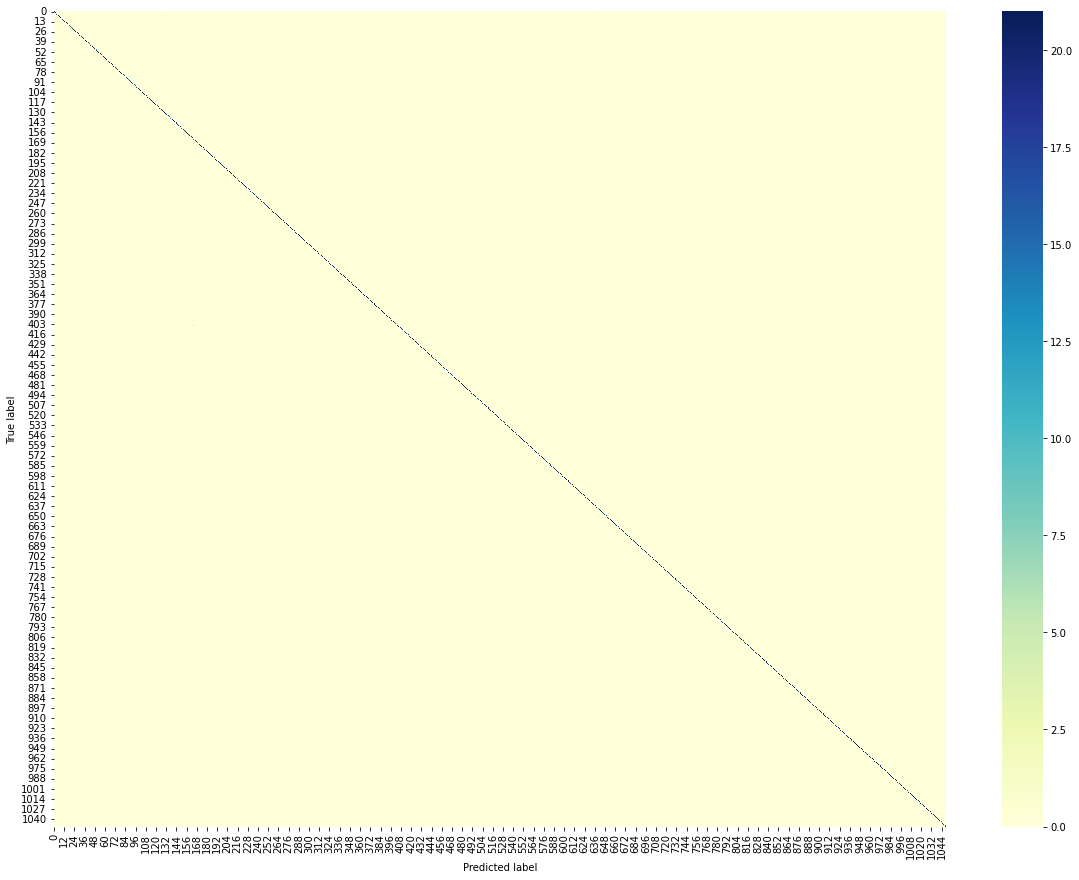

In [ ]:
plt.figure(figsize=(20, 15))
df_cm = pd.DataFrame(conf_matrix).astype(int)
heatmap = sns.heatmap(df_cm, cmap="YlGnBu")

plt.ylabel('True label')
plt.xlabel('Predicted label')
